In [1]:
import sys, tensorflow as tf
from tensorflow.keras import backend as K

print("Python:", sys.executable)
print("TF version:", tf.__version__)
print("Keras backend:", K.backend())
print("Devices:", tf.config.list_physical_devices())
print("GPU:", tf.config.list_physical_devices('GPU'))

Python: /Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/.conda/bin/python
TF version: 2.16.2
Keras backend: tensorflow
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from pathlib import Path

PROJECT_ROOT = Path.cwd()
VOC_DIR      = PROJECT_ROOT / "VOC"
IMG_DIR      = VOC_DIR / "JPEGImages"
MASK_DIR     = VOC_DIR / "SegmentationClass_Encoded_JPG"   # integer masks (0=bg, 1=dog, 2=cat)

IMG_SIZE     = (256, 256)
NUM_CLASSES  = 3
BATCH        = 8
VAL_SPLIT    = 0.2
SEED         = 42

EPOCHS_WARMUP   = 5    # encoder frozen
EPOCHS_FINETUNE = 10   # encoder unfrozen
LR_WARMUP       = 1e-4
LR_FINETUNE     = 1e-5

print("IMG_DIR:", IMG_DIR.exists())
print("MASK_DIR:", MASK_DIR.exists())

IMG_DIR: True
MASK_DIR: True


In [3]:
from pathlib import Path

# central place for checkpoints
CKPT_DIR = Path("checkpoints")
CKPT_DIR.mkdir(exist_ok=True)

print("Checkpoint directory:", CKPT_DIR.resolve())

Checkpoint directory: /Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team_YTK/checkpoints


In [5]:
img_exts = [".jpg", ".jpeg", ".png"]
img_paths = []
for ext in img_exts:
    img_paths += sorted(str(p) for p in IMG_DIR.glob(f"*{ext}"))

mask_paths = []
for p in img_paths:
    stem = Path(p).stem
    mp = MASK_DIR / f"{stem}.png"
    if not mp.exists():
        mp = MASK_DIR / f"{stem}.jpg"
    mask_paths.append(str(mp))

pairs = [(i, m) for i, m in zip(img_paths, mask_paths) if Path(m).exists()]
img_paths  = [p[0] for p in pairs]
mask_paths = [p[1] for p in pairs]

print("Found", len(img_paths), "pairs")
print(img_paths[0], "→", mask_paths[0])


Found 358 pairs
/Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team_YTK/VOC/JPEGImages/cat.0.jpg → /Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/Team_YTK/VOC/SegmentationClass_Encoded_JPG/cat.0.jpg


In [6]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input

IMG_H, IMG_W = IMG_SIZE

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return preprocess_input(img)

def load_mask(path):
    m = tf.io.read_file(path)
    m = tf.image.decode_image(m, channels=1, expand_animations=False)
    m = tf.image.resize(m, IMG_SIZE, method="nearest")
    m = tf.cast(m, tf.int32)
    return m

def load_pair(ip, mp):
    return load_img(ip), load_mask(mp)

ds_all = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
val_len = int(len(img_paths) * VAL_SPLIT)
ds_val = ds_all.take(val_len)
ds_tr  = ds_all.skip(val_len)

AUTOTUNE = tf.data.AUTOTUNE
ds_tr  = ds_tr.shuffle(100, seed=SEED).map(load_pair, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)
ds_val = ds_val.map(load_pair, num_parallel_calls=AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

imgs, masks = next(iter(ds_val))
print("Batch imgs:", imgs.shape, imgs.dtype)
print("Batch masks:", masks.shape, masks.dtype, "unique:", tf.unique(tf.reshape(masks, [-1]))[0][:10].numpy())

2025-08-28 01:29:04.779005: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-08-28 01:29:04.779062: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-28 01:29:04.779073: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-28 01:29:04.779101: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-28 01:29:04.779126: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Batch imgs: (8, 256, 256, 3) <dtype: 'float32'>
Batch masks: (8, 256, 256, 1) <dtype: 'int32'> unique: [0 1]


In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

def unet_vgg16(input_shape=(256,256,3), num_classes=3):
    vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)

    # Skip connections: use *conv layers* (not pool) to keep higher resolution features
    s1 = vgg16.get_layer("block1_conv2").output   # 256x256
    s2 = vgg16.get_layer("block2_conv2").output   # 128x128
    s3 = vgg16.get_layer("block3_conv3").output   # 64x64
    s4 = vgg16.get_layer("block4_conv3").output   # 32x32

    # Bottleneck
    b1 = vgg16.get_layer("block5_conv3").output   # 16x16

    # Decoder
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(b1)  # 16→32
    d1 = layers.Concatenate()([d1, s4])
    d1 = layers.Conv2D(512, 3, activation="relu", padding="same")(d1)
    d1 = layers.Conv2D(512, 3, activation="relu", padding="same")(d1)

    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(d1)  # 32→64
    d2 = layers.Concatenate()([d2, s3])
    d2 = layers.Conv2D(256, 3, activation="relu", padding="same")(d2)
    d2 = layers.Conv2D(256, 3, activation="relu", padding="same")(d2)

    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(d2)  # 64→128
    d3 = layers.Concatenate()([d3, s2])
    d3 = layers.Conv2D(128, 3, activation="relu", padding="same")(d3)
    d3 = layers.Conv2D(128, 3, activation="relu", padding="same")(d3)

    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(d3)   # 128→256
    d4 = layers.Concatenate()([d4, s1])
    d4 = layers.Conv2D(64, 3, activation="relu", padding="same")(d4)
    d4 = layers.Conv2D(64, 3, activation="relu", padding="same")(d4)

    # Output
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(d4)

    return models.Model(vgg16.input, outputs, name="U-Net_VGG16")

model = unet_vgg16(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES)
print("Model output shape:", model.output.shape)  # should be (None, 256, 256, 3)
model.summary()


Model output shape: (None, 256, 256, 3)


Model: "U-Net_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 28,025,667 (106.91 MB)

 Trainable params: 28,025,667 (106.91 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_WARMUP),
    loss=loss_fn,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy")]
)


In [9]:
ckpt_warmup = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(CKPT_DIR / "best_warmup.weights.h5"),
    monitor="val_sparse_categorical_accuracy",  # ← change
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",  # ← change
    mode="max",
    patience=7,
    restore_best_weights=True,
    verbose=1,
)

reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_sparse_categorical_accuracy",  # ← change
    mode="max",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)


In [10]:
for layer in model.layers:
    if "block" in layer.name:  # VGG16 encoder layers
        layer.trainable = False

history_warmup = model.fit(
    ds_tr, validation_data=ds_val,
    epochs=EPOCHS_WARMUP,
    callbacks=[ckpt_warmup, early, reduce]
)

model.save("unet_vgg16_warmup.keras")

Epoch 1/5


2025-08-28 01:30:43.543500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 30.6008 - sparse_categorical_accuracy: 0.4950
Epoch 1: val_sparse_categorical_accuracy improved from None to 0.57305, saving model to checkpoints/best_warmup.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 21.7155 - sparse_categorical_accuracy: 0.5404 - val_loss: 12.1406 - val_sparse_categorical_accuracy: 0.5730 - learning_rate: 1.0000e-04
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 9.1778 - sparse_categorical_accuracy: 0.6743
Epoch 2: val_sparse_categorical_accuracy did not improve from 0.57305
36/36 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 7.6069 - sparse_categorical_accuracy: 0.7315 - val_loss: 11.1427 - val_sparse_categorical_accuracy: 0.5659 - learning_rate: 1.0000e-04
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 6.8923 - sparse_categorical_accuracy: 0.6784
Epoch 3: val_sparse_categorical_accuracy improved from 0.57305 to 0.59681, saving model to checkpoints/best_warmup.weights.h5
36/36 ━━━━━━━━━━━━━━━━

In [12]:
# load best warmup weights before FT
model.load_weights(CKPT_DIR / "best_warmup.weights.h5")

# unfreeze everything (optionally unfreeze only top blocks)
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(LR_FINETUNE),
              loss=loss_fn,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy")])

ckpt_finetune = tf.keras.callbacks.ModelCheckpoint(
    filepath=str(CKPT_DIR / "best_finetune.weights.h5"),
    monitor="val_sparse_categorical_accuracy",
    mode="max",
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

history_finetune = model.fit(
    ds_tr,
    validation_data=ds_val,
    epochs=EPOCHS_FINETUNE,
    callbacks=[ckpt_finetune, early, reduce],
)

model.save("unet_vgg16_finetune.keras")


Epoch 1/10


/Users/khantnyarkoko/Practical-ML-by-WAI/8_final_proj/.conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 106 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.2764 - sparse_categorical_accuracy: 0.6576
Epoch 1: val_sparse_categorical_accuracy improved from None to 0.84386, saving model to checkpoints/best_finetune.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - loss: 1.0074 - sparse_categorical_accuracy: 0.6575 - val_loss: 0.8571 - val_sparse_categorical_accuracy: 0.8439 - learning_rate: 1.0000e-05
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6789 - sparse_categorical_accuracy: 0.7757
Epoch 2: val_sparse_categorical_accuracy improved from 0.84386 to 0.87056, saving model to checkpoints/best_finetune.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - loss: 0.6594 - sparse_categorical_accuracy: 0.6959 - val_loss: 0.7633 - val_sparse_categorical_accuracy: 0.8706 - learning_rate: 1.0000e-05
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6021 - sparse_categorical_accuracy: 0.7869
Epoch 3: val_sparse_categorical_accuracy improved from 0.87056 to 0.87939, saving model 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step


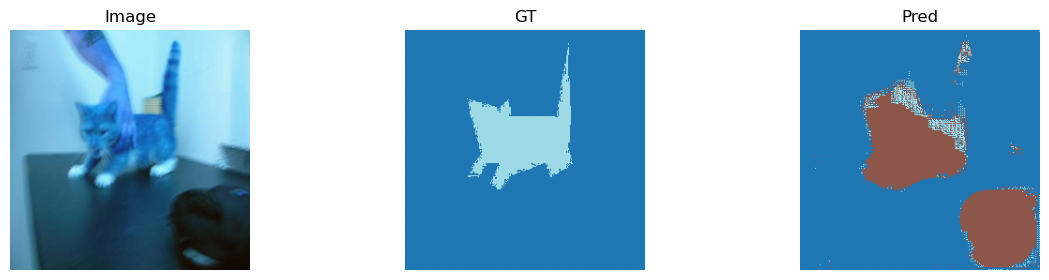

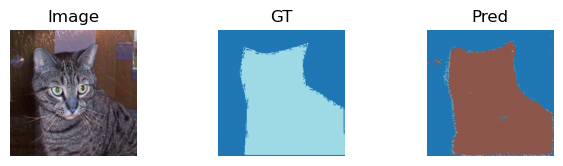

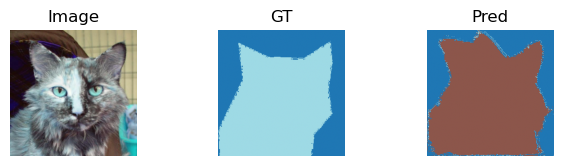

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
imgs, masks = next(iter(ds_val))

preds = model.predict(imgs)
pred_cls = np.argmax(preds, axis=-1)

plt.figure(figsize=(12,8))
for i in range(min(3, imgs.shape[0])):
    plt.subplot(3,3,3*i+1) 
    plt.imshow((imgs[i].numpy()-imgs[i].numpy().min())/(imgs[i].numpy().ptp()+1e-6)) 
    plt.title("Image") 
    plt.axis("off")
    plt.subplot(3,3,3*i+2) 
    plt.imshow(masks[i], cmap="tab20")
    plt.title("GT") 
    plt.axis("off")
    plt.subplot(3,3,3*i+3) 
    plt.imshow(pred_cls[i], cmap="tab20") 
    plt.title("Pred") 
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [16]:
# Rebuild model with same function, then:
model.load_weights(CKPT_DIR / "best_finetune.weights.h5")
